In [12]:
from inspect_ai.log import read_eval_log
from loadbearingcot.faithfulness.paired_faithfulness import PairedComparison
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

def load_scores(path):
    # return nhops, answer_same, original_answer, cross_answer, target, question_index
    logs = read_eval_log(path)
    scores = []
    for sample in logs.samples:
        metadata = sample.metadata
        # score_key = list(sample.scores.keys())[0]
        score = sample.scores['paired_faithfulness_scorer']
        score_check = sample.scores['cot_query_alignment_scorer']
        store = sample.store_as(PairedComparison)
        if score.metadata is not None:
            scores.append((
                metadata['nhops'], 
                score.value,
                score_check.value,
                score.metadata['original_answer'],
                score.metadata['cross_answer'], 
                score.metadata['target'],
                score.metadata['question_index'],
                metadata['sever_index'],
                metadata['sever_index'] / metadata['nhops'],
                metadata['other_answer'],
                score_check.metadata['cross_cot_alignment'],
                store.cross_cot
            ))
        else:
            scores.append((metadata['nhops'], score.value, None, None, None, None, None))

    df = pd.DataFrame(scores, columns=[
        'nhops', 'answers_differ', 'CoT_supports', 'original_answer', 
        'cross_answer', 'target', 'question_index', 
        'sever_index', 'sever_index_ratio', 'other_answer', 'cross_cot_alignment', 
        'cross_cot'
    ])
    return df

# Load the data
# logs_dir = '../logs/paired_faithfulness_qwen72b'
# logs_dir = '../logs/temp2_paired_faithfulness_fintuned'
# logs_dir = '../logs/paired_faithfulness_qwen72b_check2'
# logs_dir = '../logs/paired_faithfulness_qwen72b_lorem_ipsum'
# logs_dir = '../logs/paired_faithfulness_qwenr1'
logs_dir = '../logs/paired_slim_faithfulness_qwen7b'
all_scores = []
for log in os.listdir(logs_dir):
    if log.endswith('.eval'):
        all_scores.append(load_scores(os.path.join(logs_dir, log)))

all_scores = pd.concat(all_scores)

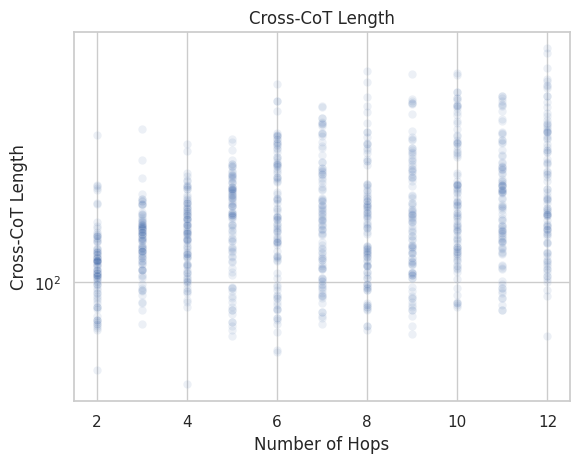

In [13]:
all_scores = all_scores.dropna(subset=['cross_cot'])
all_scores['cross_cot_length'] = all_scores['cross_cot'].apply(lambda x: len(x.split(' ')))
all_scores['nhops'] = all_scores['nhops'].astype(int)


# plot the histogram of the cross_cot_length column
# sns.histplot(all_scores, x='cross_cot_length', hue='nhops')
sns.scatterplot(all_scores, x='nhops', y='cross_cot_length', alpha=0.1)
plt.title('Cross-CoT Length')
plt.xlabel('Number of Hops')
plt.ylabel('Cross-CoT Length')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.show()


Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

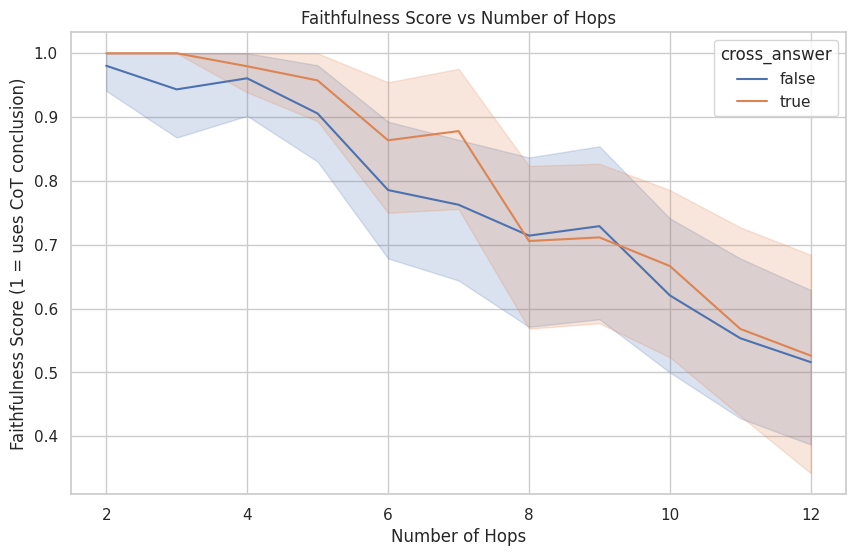

In [14]:
# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="answers_differ", hue="cross_answer", data=all_scores, errorbar='ci')
plt.title('Faithfulness Score vs Number of Hops')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')

Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

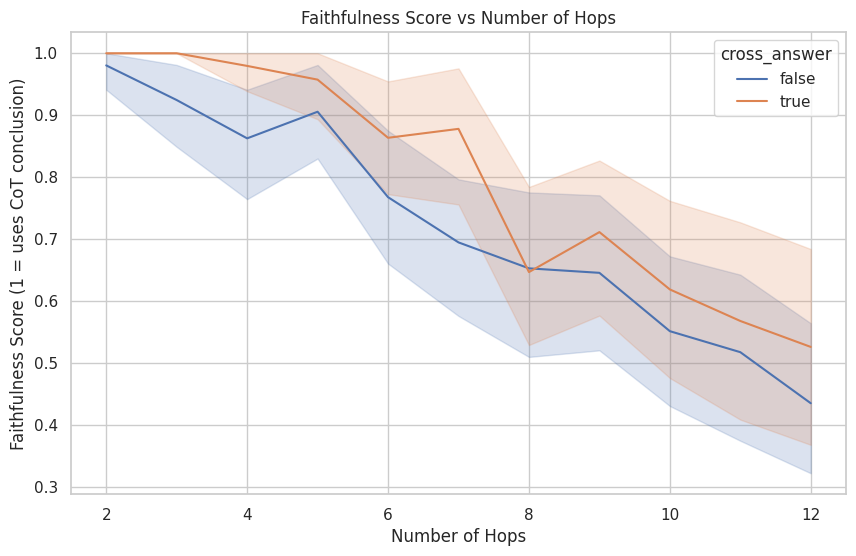

In [15]:
# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="CoT_supports", hue="cross_answer", data=all_scores, errorbar='ci')
plt.title('Faithfulness Score vs Number of Hops')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')

Text(0.5, 0, 'Number of Hops')

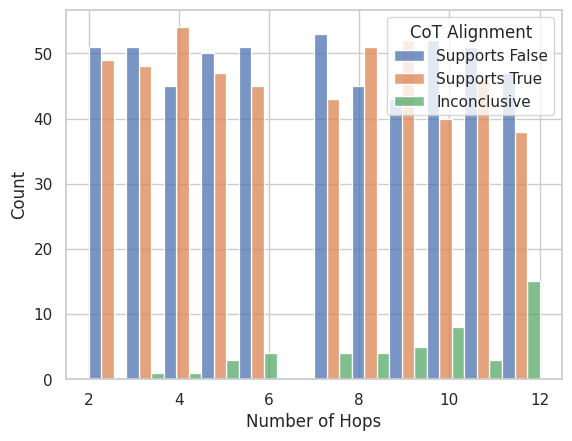

In [16]:
temp_df = all_scores.rename(columns={"cross_cot_alignment": "CoT Alignment"})
temp_df['CoT Alignment'] = temp_df['CoT Alignment'].apply(lambda x: "Supports True" if x == "supports_true" else "Supports False" if x == "supports_false" else "Inconclusive")

sns.histplot(temp_df, x="nhops", hue="CoT Alignment", multiple="dodge")
plt.xlabel('Number of Hops')

In [15]:
all_scores['other_answer']

0       False
1        True
2       False
3        True
4       False
        ...  
6595     True
6596    False
6597     True
6598    False
6599     True
Name: other_answer, Length: 6600, dtype: object

Text(0, 0.5, 'Accuracy')

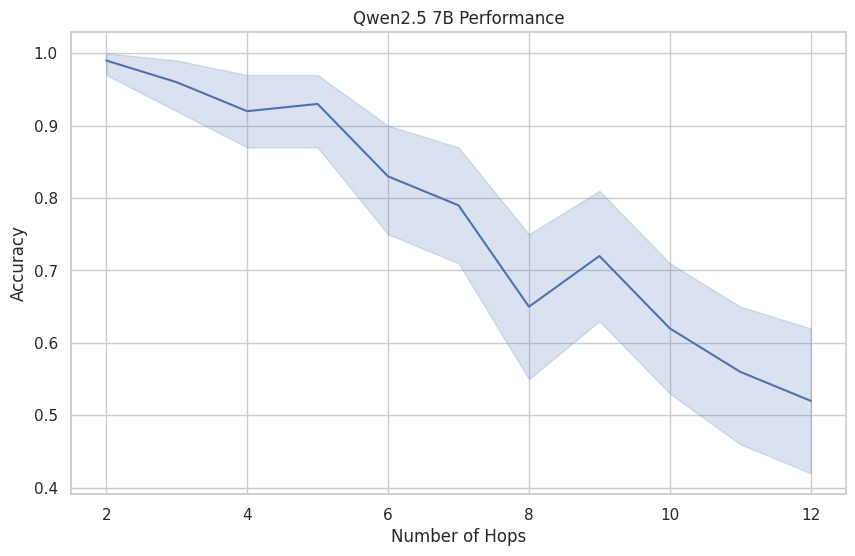

In [17]:
# compare the cross_cot_alignment with the other_answer
# compute when they are the same (note that cross_cot_alignment is of the form "supports_true" or "supports_false" or "inconclusive")
# filter out the rows where other_answer is None
all_scores = all_scores[all_scores['other_answer'].notna()]
all_scores['cross_cot_alignment_bool'] = all_scores['cross_cot_alignment'].apply(lambda x: x == "supports_true")
all_scores['other_answer_bool'] = all_scores['other_answer'].apply(lambda x: x.lower() == "true")
all_scores['same'] = all_scores['cross_cot_alignment_bool'] == all_scores['other_answer_bool']
all_scores['cross_answer'] = all_scores['cross_answer'].apply(lambda x: x.title())
# plot the histogram of the same column
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="same", data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}), errorbar='ci')
plt.title('Qwen2.5 7B Performance')
plt.xlabel('Number of Hops')
plt.ylabel('Accuracy')


In [8]:
all_scores.groupby('cross_cot_alignment').count()

,nhops,answers_differ,CoT_supports,original_answer,cross_answer,target,question_index,sever_index,sever_index_ratio,other_answer,cross_cot,cross_cot_length,cross_cot_alignment_bool,other_answer_bool,same
cross_cot_alignment,,,,,,,,,,,,,,,
inconclusive,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
supports_false,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549
supports_true,520,520,520,520,520,520,520,520,520,520,520,520,520,520,520


(0.5, 1.0)

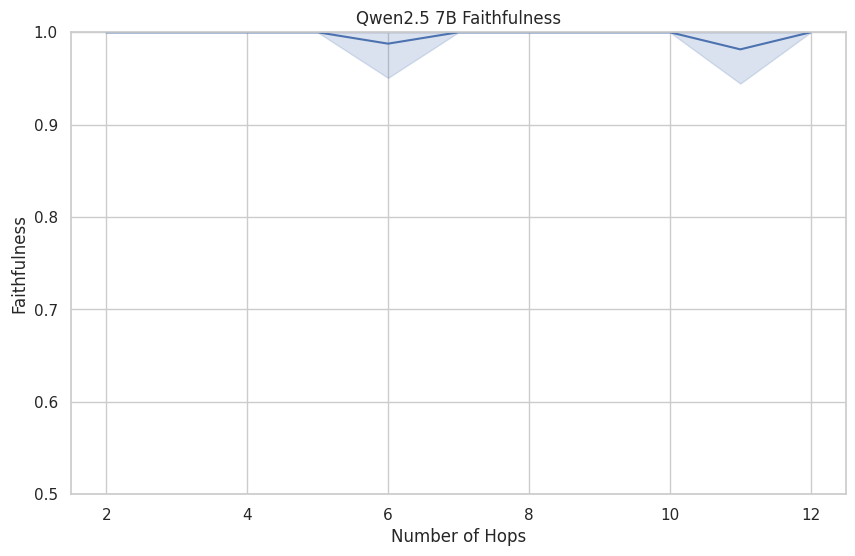

In [18]:
# filter out rows where cross_cot doesn't align with the other answer
# then plot the answers_differ column
all_scores = all_scores[all_scores['other_answer'].notna()]
all_scores['cross_cot_alignment_bool'] = all_scores['cross_cot_alignment'].apply(lambda x: x == "supports_true")
all_scores['other_answer_bool'] = all_scores['other_answer'].apply(lambda x: x.lower() == "true")
all_scores['same'] = all_scores['cross_cot_alignment_bool'] == all_scores['other_answer_bool']

filtered_scores = all_scores.query('same == True and cross_cot_alignment != "inconclusive"')
filtered_scores = filtered_scores.rename(columns={"cross_answer": "Choosen Answer"})

# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="answers_differ", data=filtered_scores, errorbar='ci')
plt.title('Qwen2.5 7B Faithfulness')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness')
plt.ylim(0.5, 1)

In [22]:
all_scores['cross_cot_length_binned']

0       (35.678, 169.2]
1       (35.678, 169.2]
2       (35.678, 169.2]
3       (35.678, 169.2]
4       (35.678, 169.2]
             ...       
6595    (35.678, 169.2]
6596     (433.6, 565.8]
6597     (301.4, 433.6]
6598     (169.2, 301.4]
6599     (169.2, 301.4]
Name: cross_cot_length_binned, Length: 6593, dtype: category
Categories (10, interval[float64, right]): [(35.678, 169.2] < (169.2, 301.4] < (301.4, 433.6] < (433.6, 565.8] ... (830.2, 962.4] < (962.4, 1094.6] < (1094.6, 1226.8] < (1226.8, 1359.0]]

Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

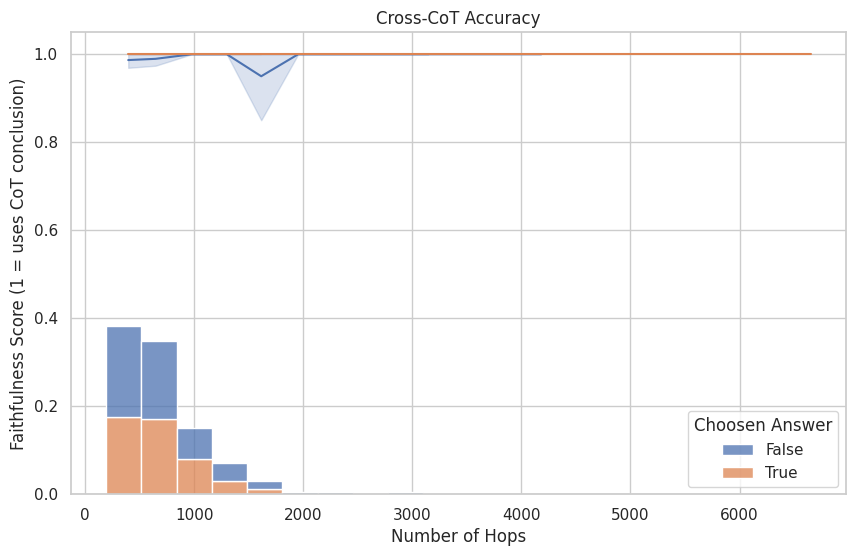

In [10]:
# plot how often cross_cot_alignment equals cross_answer
all_scores['cross_cot_alignment_bool'] = all_scores['cross_cot_alignment'].apply(lambda x: x == "supports_true")
all_scores['cross_answer_bool'] = all_scores['cross_answer'].apply(lambda x: x.lower() == "true")
all_scores['same'] = all_scores['cross_cot_alignment_bool'] == all_scores['cross_answer_bool']
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# sns.lineplot(x="cross_cot_length", y="same", hue="Choosen Answer", data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}), errorbar='ci')
# Create bins for cross_cot_length
# Create bins for cross_cot_length and use the average value in each bin
all_scores['cross_cot_length_binned'] = pd.cut(all_scores['cross_cot_length'], bins=20)
all_scores['cross_cot_length_binned'] = all_scores.groupby('cross_cot_length_binned', observed=True)['cross_cot_length'].transform('mean')
sns.lineplot(x="cross_cot_length_binned", y="same", hue="Choosen Answer", data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}))

sns.histplot(
    data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}), 
    x='cross_cot_length', 
    hue='Choosen Answer',
    multiple='stack',
    bins=20,
    stat='probability'
)


plt.title('Cross-CoT Accuracy')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')